# Spectral Mismatch Modifiers
Learn to use spectral mismatch modifiers with this notebook!
Feel free to add other models, be sure to update the index and give you credit ;)

Table of contents:
1. [Setup](#setup-the-environment)
1. [N. Martin & J. M. Ruiz Experimental Mismatch Modifier](#n-martin--j-m-ruiz-experimental-mismatch-modifier)

Authors:
* Echedey Luis (@echedey-ls), 2023 Feb

## Setup the environment

Run this before anything else.

In [6]:
# Show matplotlib's figures in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# And pvlib
import pvlib

### N. Martin & J. M. Ruiz Mismatch Modifier
This modifier takes into account the spectral responses of several solar cell
material, characterized by the airmass and the clearness index, as two
independent variables. In fact, there are three different modifiers, each one
for each component (``poa_direct``, ``poa_sky_diffuse``,
``poa_ground_diffuse``)

The formula for each component has three coefficients; we are lucky the authors
of this model computed fitting values for m-Si, p-Si and a-Si!

First step is get to the effective irradiance. For simplicity, we will copy the
procedure explained in the tutorial ``tmy_to_power.ipynb`` to obtain it.
Please refer to it to get a more in depth explanation.

In [7]:
site = pvlib.location.Location(40.4534, -3.7270, altitude=664,
                               name='IES-UPM, Madrid')

surface_tilt = 40
surface_azimuth = 180  # Pointing South

pvgis_data, _, _, _ = \
    pvlib.iotools.get_pvgis_tmy(site.latitude, site.longitude,
                                map_variables=True,
                                startyear=2005, endyear=2015)
pvgis_data.index = [ts.replace(year=2022) for ts in pvgis_data.index]

In [8]:
weather_data = pvgis_data['2022-09-03':'2022-09-06']

solar_pos = site.get_solarposition(weather_data.index)

extra_rad = pvlib.irradiance.get_extra_radiation(weather_data.index)

poa_sky_diffuse = \
    pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,
                               weather_data['dhi'],  weather_data['dni'],
                               extra_rad, solar_pos['apparent_zenith'],
                               solar_pos['azimuth'])

poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(surface_tilt,
                                                         weather_data['ghi'])

aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth,
                           solar_pos['apparent_zenith'], solar_pos['azimuth'])

# Let's consider this the irradiances without spectral modifiers
# We can calculate the mismatch before and then create a "poa_irrad" var for
# modified irradiances, but we are also doing this to compare later.
# 'spectrum.martin_ruiz' result is designed to make it
# easy to multiply each modifier and the irradiance component with a single
# line of code, if you get this dataframe before.
poa_irrad = pvlib.irradiance.poa_components(aoi,
                                            weather_data['dni'],
                                            poa_sky_diffuse,
                                            poa_ground_diffuse)

Here comes the modifier. Let's calculate it with the airmass and clearness
index.

In [9]:
# First, let's find the airmass and the clearness index
# Little caution: default values for this model were fitted obtaining the
# airmass through the kasten1966 method, not used by default
airmass = site.get_airmass(solar_position=solar_pos, model='kasten1966')
clearness_index = \
    pvlib.irradiance.clearness_index(ghi=weather_data['ghi'],
                                     solar_zenith=solar_pos['zenith'],
                                     extra_radiation=extra_rad)

# Get the spectral mismatch modifiers
spectral_modifiers = \
    pvlib.spectrum.martin_ruiz(clearness_index, airmass['airmass_absolute'],
                               module_type='monosi')

And then we can find the 3 components modified irradiances by means of a simple
multiplication.

Note, however, that neither this does modify ``poa_global`` nor
``poa_diffuse``, so we should update the dataframe afterwards, again with
``irradiance.poa_components``.

In [10]:
poa_irrad_modified = poa_irrad * spectral_modifiers
# We want global modified irradiance - so let's add them
poa_irrad_modified['poa_global'] = (poa_irrad_modified['poa_direct']
                                    + poa_irrad_modified['poa_sky_diffuse']
                                    + poa_irrad_modified['poa_ground_diffuse'])

Finally, let's plot the incident vs modified global irradiances, and their
difference.

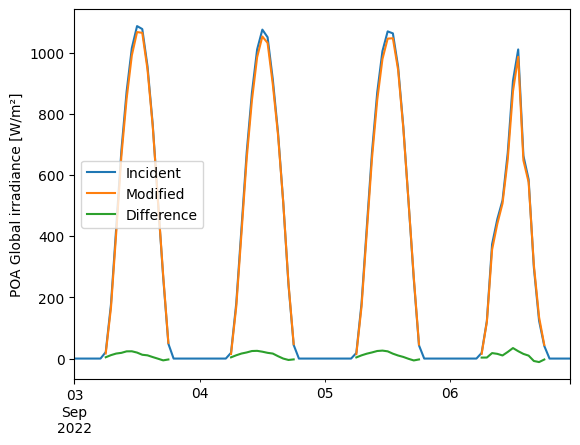

In [11]:
poa_irrad_global_diff = (poa_irrad['poa_global']
                         - poa_irrad_modified['poa_global'])
poa_irrad['poa_global'].plot()
poa_irrad_modified['poa_global'].plot()
poa_irrad_global_diff.plot()
plt.legend(['Incident', 'Modified', 'Difference'])
plt.ylabel('POA Global irradiance [W/m²]')
plt.show()